# Figures for flat10MIP land carbon paper


### Import

In [1]:
import numpy as np
import numpy.matlib
import numpy.ma as ma

import xarray as xr
#xr.set_options(enable_cftimeindex=True)
from xarray.coding.times import CFTimedeltaCoder

import time
import cftime
import netCDF4 as nc
from datetime import timedelta

import pandas as pd

#import xcdat

import matplotlib as mpl
import matplotlib.pyplot as plt

#import cartopy.crs as ccrs
#from cartopy.util import add_cyclic_point

import glob


## notes on packages to add to this kernel
import nc_time_axis
import cartopy.crs as ccrs
import cartopy

# custom functions for loading full data fields
from loading_function_flat10 import load_one_model_onevar, load_grid, select_time_slice, weighted_temporal_mean, load_observations 


### Set up lists

In [2]:
outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'

# modellist_orig= ['ACCESS-ESM1-5',  
#             'CESM2',    
#             'GFDL-ESM4',  
#             'GISS_E2.1',  
#             'NorESM2-LM',
#             'MPI-ESM1-2-LR',
#             'CNRM-ESM2-1',
#             'HadCM3LC-Bris',
#             'UKESM1.2']
# modellist=modellist_orig

runlist = ['flat10','flat10_zec','flat10_cdr']
# use a wildcard to capture different ways the folders and runs are named across models
runlist_wc = ['*lat10','*zec','*cdr']

varlist_load=['cVeg','cSoil','cLitter','nbp','gpp','rh','tas','pr'] #, 'gpp','fgco2', 'ra', 'rh']#, 'npp'] # not working beyond nbp for norESM
#varlist_analyze=['cVeg','cSoil','cTot','cLitter','nbp','gpp','rh','tas','pr']
varlist_analyze=['cVeg','cSoil','cTot','cLitter','nbp','gpp','rh','tas','pr']
varlist=varlist_load
unitslist=['kgC m-2','kgC m-2','kgC m-2','kgC m-2 s-1','kgC m-2 s-1','kgC m-2 s-1']

# there seems to be a problem with ra for NorESM

modelcolors=['tab:blue','tab:orange','tab:green','tab:red','tab:gray','tab:purple','tab:cyan','gold','tab:brown']

# to match Sanderson paper:
modellist_ben=['ACCESS-ESM1-5',
                'CESM2',
                'GFDL-ESM4',
                'GISS_E2.1',
                'NorESM2-LM',
                'MPI-ESM1-2-LR',
                'CNRM-ESM2-1',
                'UKESM1.2',
                # 'UVic-ESCM-2-10',
                'HadCM3LC-Bris']
# bencolors=["tab:cyan","tab:olive","tab:green","tab:red","tab:gray","tab:pink","limegreen","tab:brown", "slateblue","gold"]
bencolors=["tab:cyan","tab:olive","tab:green","tab:red","tab:gray","tab:pink","limegreen","tab:brown", "gold"]

# -----select either original colors or ben's colors and order
modellist=modellist_ben
modelcolors=bencolors

latlist=['global','highlat','midlat','troplat']

markerlist=['o','v','^','<','>','s','*','P','d','X']


vegcolor=color=np.divide([176, 208, 65],255)
littercolor=np.divide([240, 155, 56],255)
soilcolor=np.divide([164, 119, 39],255)


# latcolors=['#94E86B','#6B74E8','#E8906B','red'] #
# latcolors=['#E8B46B','#6BE0E8','#6B91E8']
# latcolors=['#FE7180','#FFFA70','#70CFFF']
# latcolors=[vegcolor, littercolor,soilcolor]
greenpurplebrown=['#B9CA60','#574F91','#D19563'] #green, purple, brown
 # latcolors=['#94E86B','#6B74E8','#E8906B']
# latcolors=['#E8B46B','#6BE0E8','#6B91E8']
# latcolors=['#FE7180','#FFFA70','#70CFFF']
pinkpurpleblue=['#EA7B7B','#7D589E','#C0D0DD']

subplotlabelnames=['a)','b)','c)','d)','e)','f)','g)','h)','i)','j)','k)','l)']

In [3]:
#unitconversions
sperday=60*60*24
speryr=60*60*24*365

PgperKg = 1e-12
# to convert kg m-2 s-1 to kg/m2/yr multiply by speryr

## Load Data

In [4]:
# initialize a dictionary to hold grid data
data_dict={}
data_dict = load_grid(data_dict,modellist)

ACCESS-ESM1-5 getting grid info
CESM2 getting grid info
GFDL-ESM4 getting grid info
GISS_E2.1 getting grid info
NorESM2-LM getting grid info
MPI-ESM1-2-LR getting grid info
CNRM-ESM2-1 getting grid info
UKESM1.2 getting grid info
HadCM3LC-Bris getting grid info


In [5]:
ds_C_global = xr.open_dataset("C_metrics_matrix_S.nc")

In [6]:
# load co2 data

co2_flat10=pd.read_csv('globalmean_output/atmospheric_co2_flat10.csv')
co2_flat10_zec=pd.read_csv('globalmean_output/atmospheric_co2_flat10-zec.csv')
co2_flat10_cdr=pd.read_csv('globalmean_output/atmospheric_co2_flat10-cdr.csv')

# arg=co2_flat10_cdr['ACCESS-ESM1-5'].plot()

# co2_flat10_cdr

# UKESM and GISS is named incorrectly, correct the label
co2_flat10.rename(columns={'UKESM': 'UKESM1.2','GISS':'GISS_E2.1'}, inplace=True)
co2_flat10_zec.rename(columns={'UKESM': 'UKESM1.2','GISS':'GISS_E2.1'}, inplace=True)
co2_flat10_cdr.rename(columns={'UKESM': 'UKESM1.2','GISS':'GISS_E2.1'}, inplace=True)

# and MPI data is stored in brackets for some reason
co2_flat10['MPI-ESM1-2-LR'] = co2_flat10['MPI-ESM1-2-LR'].str.strip('[]').astype(float)
co2_flat10_zec['MPI-ESM1-2-LR'] = co2_flat10_zec['MPI-ESM1-2-LR'].str.strip('[]').astype(float)
co2_flat10_cdr['MPI-ESM1-2-LR'] = co2_flat10_cdr['MPI-ESM1-2-LR'].str.strip('[]').astype(float)

# co2_flat10

In [7]:
# load observations of veg and soil C pools

cSoil_obs, cVeg_obs, cSoil_obs_zonal, cVeg_obs_zonal = load_observations(1)

creating zonal average output
CESM2 getting grid info


## Create tables of changes

### table by carbon pool

In [8]:
#-- table of changes


# rows are models
# columns are (%land, %litter, %soil, total [PgC])
# one set for each of (initial stocks, change during emissions, change after net zero, change after cumulative zero)



varlisthere=['cTot','cVeg','cLitter','cSoil']

# global only first
# l=0
for l in range(len(latlist)):
    initialC = np.empty([len(modellist),len(varlisthere)])
    emissC= np.empty([len(modellist),len(varlisthere)])
    AfterNZ= np.empty([len(modellist),len(varlisthere)])
    CumNZ= np.empty([len(modellist),len(varlisthere)])
    
    for m in range(len(modellist)):
        model=modellist[m]
        # mcolor=modelcolors[m]
        
        # for l in range(len(latlist)):
        
        for vi in range(len(varlisthere)):
            if vi==0:
                # total
                # vi=0
                e=0
                timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlisthere[0], latrange=latlist[l])
                initC=np.mean(timeseries.data[0:9])
                nzC=np.mean(timeseries.data[90:109])
                e=1
                timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlisthere[0], latrange=latlist[l])
                afternzC=np.mean(timeseries.data[190:199])
                e=2
                timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlisthere[0], latrange=latlist[l])
                cumnz=np.mean(timeseries.data[190:199])
                
                initialC[m,vi]=initC
                emissC[m,vi]=nzC-initC
                AfterNZ[m,vi]=afternzC - nzC
                CumNZ[m,vi]=cumnz-initC

            else: 
                # (as % of total)
                e=0
                timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlisthere[vi], latrange=latlist[l])
                initC=np.mean(timeseries.data[0:9])
                nzC=np.mean(timeseries.data[90:109])
                e=1
                timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlisthere[vi], latrange=latlist[l])
                afternzC=np.mean(timeseries.data[190:199])
                e=2
                timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlisthere[vi], latrange=latlist[l])
                cumnz=np.mean(timeseries.data[190:199])
                
                initialC[m,vi]=100*initC/initialC[m,0]
                emissC[m,vi]=100*(nzC-initC)/emissC[m,0]
                AfterNZ[m,vi]=100*(afternzC - nzC)/AfterNZ[m,0]
                CumNZ[m,vi]=100*(cumnz-initC)/CumNZ[m,0] 


    # add the multi model mean and standard deviation
    initialC=np.vstack((initialC,np.nanmean(initialC,0)))
    emissC=np.vstack((emissC,np.nanmean(emissC,0)))
    AfterNZ=np.vstack((AfterNZ,np.nanmean(AfterNZ,0)))
    CumNZ=np.vstack((CumNZ,np.nanmean(CumNZ,0)))
    
    initialC=np.vstack((initialC,np.nanstd(initialC,0)))
    emissC=np.vstack((emissC,np.nanstd(emissC,0)))
    AfterNZ=np.vstack((AfterNZ,np.nanstd(AfterNZ,0)))
    CumNZ=np.vstack((CumNZ,np.nanstd(CumNZ,0)))
    
    index_mdls= modellist.copy()
    index_mdls.append('Multi-model Mean')
    index_mdls.append('Multi-model Standard Dev.')
    
    
    
     # #-- add output to a pandas data frames
    column_names=["Total C [PgC]", "% Vegetation", "% Litter", "% Soil"]
    row_names = index_mdls
    data_arrays = [initialC, emissC, AfterNZ, CumNZ]
    group_names = ["Initial Carbon Content","Delta after Emissions Phase", "Following Net-Zero Emissions", "At Cumulative Zero Emissions"]
    
    dfs = []
    
    for data, group in zip(data_arrays, group_names):
        df = pd.DataFrame(data, columns=column_names, index=row_names)
        df["Group"] = group
        dfs.append(df)
    
    # Combine into one DataFrame
    veg_stock_delta = pd.concat(dfs)
    
    if l==0:
        veg_stock_delta_global=veg_stock_delta
    elif l==1:
        veg_stock_delta_highlat=veg_stock_delta
    elif l==2:
        veg_stock_delta_midlat=veg_stock_delta
    else:
        veg_stock_delta_troplat=veg_stock_delta


### Table by latitude

In [9]:
#-- table of changes for lat distribution


# rows are models
# columns are (global,highlat, midlat, lowlat)
# one set for each of (initial stocks, change during emissions, change after net zero, change after cumulative zero)



varlisthere=['cTot']#,'cVeg','cLitter','cSoil']

# global only first
# l=0
initialC = np.empty([len(modellist),len(latlist)])
emissC= np.empty([len(modellist),len(latlist)])
AfterNZ= np.empty([len(modellist),len(latlist)])
CumNZ= np.empty([len(modellist),len(latlist)])

for l in range(len(latlist)):
    for m in range(len(modellist)):
        model=modellist[m]
        # mcolor=modelcolors[m]
        
        # for l in range(len(latlist)):
        
        for vi in range(len(varlisthere)):

            e=0 # flat10
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlisthere[0], latrange=latlist[l])
            initC=np.mean(timeseries.data[0:9])
            nzC=np.mean(timeseries.data[90:109])
            
            e=1 #flat10_zec
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlisthere[0], latrange=latlist[l])
            # nzC=np.mean(timeseries.data[0:9])
            afternzC=np.mean(timeseries.data[190:199])
            
            e=2 #flat10_cdr
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlisthere[0], latrange=latlist[l])
            cumnz=np.mean(timeseries.data[190:199])
            
            initialC[m,l]=initC
            emissC[m,l]=nzC-initC
            AfterNZ[m,l]=afternzC - nzC
            CumNZ[m,l]=cumnz-initC



# add the multi model mean and standard deviation
initialC=np.vstack((initialC,np.nanmean(initialC,0)))
emissC=np.vstack((emissC,np.nanmean(emissC,0)))
AfterNZ=np.vstack((AfterNZ,np.nanmean(AfterNZ,0)))
CumNZ=np.vstack((CumNZ,np.nanmean(CumNZ,0)))

initialC=np.vstack((initialC,np.nanstd(initialC,0)))
emissC=np.vstack((emissC,np.nanstd(emissC,0)))
AfterNZ=np.vstack((AfterNZ,np.nanstd(AfterNZ,0)))
CumNZ=np.vstack((CumNZ,np.nanstd(CumNZ,0)))

index_mdls= modellist.copy()
index_mdls.append('Multi-model Mean')
index_mdls.append('Multi-model Standard Dev.')



 # #-- add output to a pandas data frames
column_names=["Total C [PgC]", "Highlat C [PgC]", "Midlat C [PgC]", "Lowlat C [PgC]"]
row_names = index_mdls
data_arrays = [initialC, emissC, AfterNZ, CumNZ]
group_names = ["Initial Carbon Content","Delta after Emissions Phase", "Following Net-Zero Emissions", "At Cumulative Zero Emissions"]

dfs = []

for data, group in zip(data_arrays, group_names):
    df = pd.DataFrame(data, columns=column_names, index=row_names)
    df["Group"] = group
    dfs.append(df)

# Combine into one DataFrame
veg_stock_delta_cTot = pd.concat(dfs)
    



### Lead lag tables

In [10]:
# table of lead/lag vs net zero year
l=0


## initialize arrays
leadlag_Tot=np.empty(len(modellist)+2)
leadlag_Veg=np.empty(len(modellist)+2)
leadlag_Soil=np.empty(len(modellist)+2)
leadlag_Litter=np.empty(len(modellist)+2)
leadlag_tas=np.empty(len(modellist)+2)
leadlag_co2=np.empty(len(modellist)+2)

for m in range(len(modellist)):
    model=modellist[m]
    # mcolor=modelcolors[m]


    ##=-------###
    var='cTot'
    e=0
    timeseriesE=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                   var=var, latrange=latlist[l])
    initC=timeseriesE.data[1:10].mean()

    e=2
    timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                   var=var, latrange=latlist[l])
    
    Cts=np.append(timeseriesE.data[1:99].values, timeseries.data[1:199].values) - initC.values

    # add dot at maximum value        
    leadlag = np.argwhere(Cts==np.max(Cts))[0] - 149 # subtract they year of netzero
    #np.max(Cts)

    leadlag_Tot[m]=leadlag[0].astype('int')

        ##=-------###
    var='cVeg'
    e=0
    timeseriesE=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                   var=var, latrange=latlist[l])
    initC=timeseriesE.data[1:10].mean()

    e=2
    timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                   var=var, latrange=latlist[l])
    
    Cts=np.append(timeseriesE.data[1:99].values, timeseries.data[1:199].values) - initC.values

    # add dot at maximum value        
    leadlag = np.argwhere(Cts==np.max(Cts))[0] - 149 # subtract they year of netzero
    #np.max(Cts)

    leadlag_Veg[m]=leadlag[0]
    
    ##=-------###
    var='cSoil'
    e=0
    timeseriesE=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                   var=var, latrange=latlist[l])
    initC=timeseriesE.data[1:10].mean()

    e=2
    timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                   var=var, latrange=latlist[l])
    
    Cts=np.append(timeseriesE.data[1:99].values, timeseries.data[1:199].values) - initC.values

    # add dot at maximum value        
    leadlag = np.argwhere(Cts==np.max(Cts))[0] - 149 # subtract they year of netzero
    #np.max(Cts)

    leadlag_Soil[m]=leadlag[0]

    ##=-------###
    var='cLitter'
    e=0
    timeseriesE=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                   var=var, latrange=latlist[l])
    initC=timeseriesE.data[1:10].mean()
    if initC.isnull(): # no Litter data
        leadlag_Litter[m]=np.nan
    else:
        e=2
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=var, latrange=latlist[l])
        
        Cts=np.append(timeseriesE.data[1:99].values, timeseries.data[1:199].values) - initC.values
    
        # add dot at maximum value        
        leadlag = np.argwhere(Cts==np.max(Cts))[0] - 149 # subtract they year of netzero
        #np.max(Cts)
    
        leadlag_Litter[m]=leadlag[0].astype('int')

    ##=-------###
    var='tas'
    e=0
    timeseriesE=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                   var=var, latrange=latlist[l])
    initC=timeseriesE.data[1:10].mean()

    e=2
    timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                   var=var, latrange=latlist[l])
    
    Cts=np.append(timeseriesE.data[1:99].values, timeseries.data[1:199].values) - initC.values

    # add dot at maximum value        
    leadlag = np.argwhere(Cts==np.max(Cts))[0] - 149 # subtract they year of netzero
    #np.max(Cts)

    leadlag_tas[m]=leadlag[0]


    ##=-------###
    var='co2'
    co2ts=co2_flat10_cdr[model]#*ppm2Pg
    leadlag = np.argwhere(co2ts==np.max(co2ts))[0] - 149 # subtract they year of netzero

    leadlag_co2[m]=leadlag[0]


# add the multi model mean and standard deviation

# # add the multi model mean and standard deviation
leadlag_Tot[m+1]=np.mean(leadlag_Tot)
leadlag_Tot[m+2]=np.std(leadlag_Tot)
leadlag_Veg[m+1]=np.mean(leadlag_Veg)
leadlag_Veg[m+2]=np.std(leadlag_Veg)
leadlag_Soil[m+1]=np.mean(leadlag_Soil)
leadlag_Soil[m+2]=np.std(leadlag_Soil)
leadlag_Litter[m+1]=np.nanmean(leadlag_Litter)
leadlag_Litter[m+2]=np.nanstd(leadlag_Litter)
leadlag_tas[m+1]=np.mean(leadlag_tas)
leadlag_tas[m+2]=np.std(leadlag_tas)
leadlag_co2[m+1]=np.mean(leadlag_co2)
leadlag_co2[m+2]=np.std(leadlag_co2)

# #-- add output to a pandas data frame
leadlagpeak = pd.DataFrame({})
leadlagpeak['cTot']=leadlag_Tot
leadlagpeak['cVeg']=leadlag_Veg
leadlagpeak['cLitter']=leadlag_Litter
leadlagpeak['cSoil']=leadlag_Soil
leadlagpeak['tas']=leadlag_tas
leadlagpeak['co2']=leadlag_co2

index_mdls= modellist.copy()
index_mdls.append('Multi-model Mean')
index_mdls.append('Multi-model Standard Dev.')
leadlagpeak.index=index_mdls

# save it for this latitude band
leadlagpeak_global_cdr=leadlagpeak




/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


# Grouped bar graphs by latitude and carbon pool

### by latitude

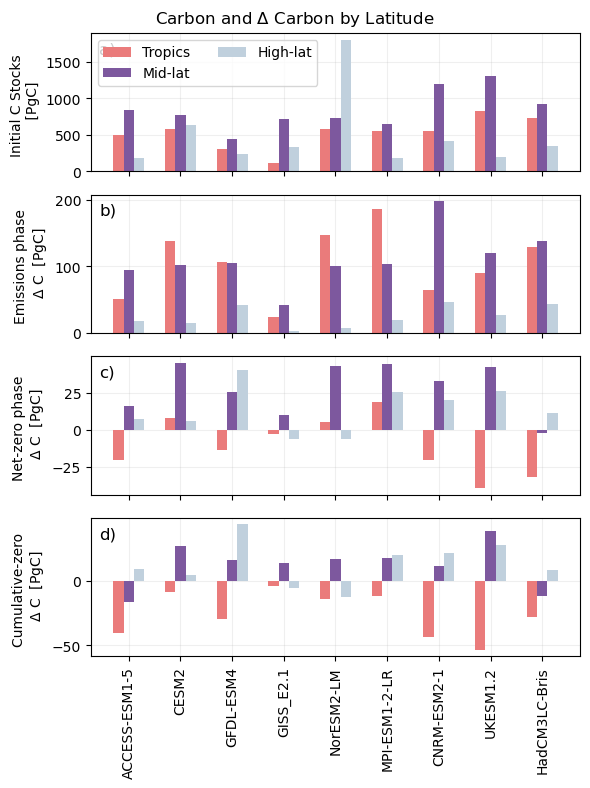

In [11]:


#---- make grouped not stacked

# 

labels= ['Tropics','Mid-lat','High-lat']
# column_names=["Total C [PgC]", "Highlat C [PgC]", "Midlat C [PgC]", "Lowlat C [PgC]"]
group_names = ["Initial Carbon Content","Delta after Emissions Phase", "Following Net-Zero Emissions", "At Cumulative Zero Emissions"]
# g=0
lat_components = [ 'Lowlat C [PgC]', 'Midlat C [PgC]', 'Highlat C [PgC]'] #['Total C [PgC]', 'Lowlat C [PgC]', 'Midlat C [PgC]', 'Highlat C [PgC]']
n_lat=len(lat_components)

bar_width=0.2

#axes=axes.flatten()


hatchlist=['','o','xx','']#'//']
alphalist=[1,0.3,0.5,.8]
latcolors=pinkpurpleblue


df=veg_stock_delta_cTot
fig, axes = plt.subplots(4,1,figsize=(6, 8))

for g in range(len(group_names)):
    for m in range(len(modellist)):
        model=modellist[m]
        mcolor=modelcolors[m]
    
        for l in range(n_lat):

            colname = lat_components[l]
            value = df.loc[(df.index == model) & (df['Group'] == group_names[g]), colname].values[0]
    
            # Compute x-position: shift each lat component by bar_width
            xpos = m + (l - n_lat / 2) * bar_width + bar_width / 2
    
            axes[g].bar(xpos,
                        value,
                        width=bar_width,
                        #hatch=hatchlist[l],
                        #color=mcolor, #if l != 0 else 'white',  # white for Total, color for others
                        color=latcolors[l],
                        #edgecolor=mcolor,
                        #alpha=alphalist[l],
                        label=f'{labels[l]}' if g == 0 and m==0 else None ,#label=f'{model}_{colname}' if g == 0 else None  # only label in first group
                        )

    
    axes[g].set_axisbelow(True)
    axes[g].grid(alpha=0.2)
    axes[g].annotate(subplotlabelnames[g],
                     xy=(0, 1), xycoords='axes fraction',
                     xytext=(+0.5, -0.5), textcoords='offset fontsize',
                     fontsize='large', verticalalignment='top')

    # Only show x-axis ticks on the last subplot
    if g == len(group_names) - 1:
        axes[g].set_xticks(np.arange(len(modellist)))
        axes[g].set_xticklabels(modellist, rotation=90)
    else:
        axes[g].set_xticks(np.arange(len(modellist)))
        axes[g].tick_params(labelbottom=False)


axes[0].set_ylabel('Initial C Stocks \n [PgC]')
axes[1].set_ylabel('Emissions phase \n $\Delta$ C  [PgC]')
axes[2].set_ylabel('Net-zero phase \n $\Delta$ C  [PgC]')
axes[3].set_ylabel('Cumulative-zero \n $\Delta$ C  [PgC]')

axes[0].legend(ncol=2)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle("Carbon and $\Delta$ Carbon by Latitude", fontsize=12)#,ha='center')






# plt.show()
plt.savefig("figures/bar_latchange_PgC.pdf", bbox_inches='tight')
plt.savefig("figures/bar_latchange_PgC.png", bbox_inches='tight')
plt.show()
plt.close()

### by carbon pool

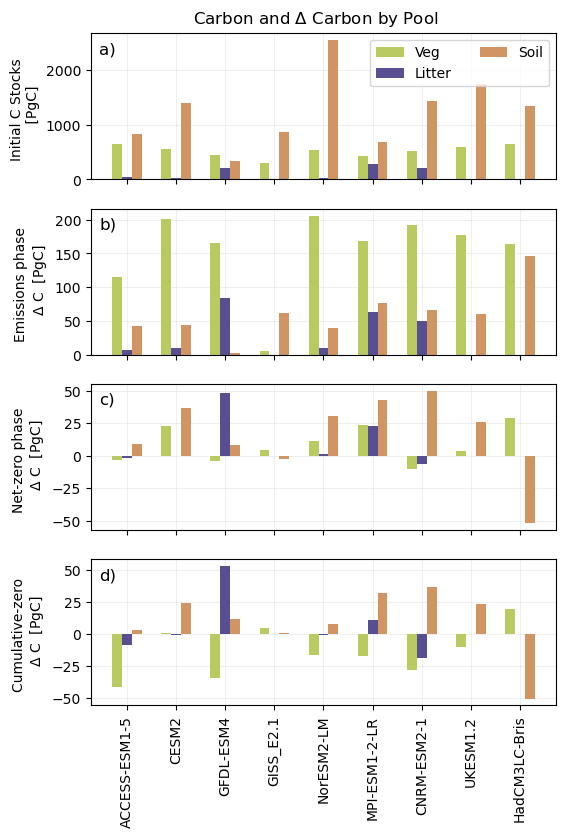

In [12]:


#---- make grouped not stacked, but for veg, soil, litter, total
# bar graph of % veg % soil
# 

column_names=["Total C [PgC]", "% Vegetation", "% Litter", "% Soil"]
plot_cols=["% Vegetation", "% Litter", "% Soil"]
labels=["Veg", "Litter", "Soil"]
group_names = ["Initial Carbon Content","Delta after Emissions Phase", "Following Net-Zero Emissions", "At Cumulative Zero Emissions"]
# g=0

    # if l==0:
    #     veg_stock_delta_global=veg_stock_delta
    # elif l==1:
    #     veg_stock_delta_highlat=veg_stock_delta
    # elif l==2:
    #     veg_stock_delta_midlat=veg_stock_delta
    # else:
    #     veg_stock_delta_troplat=veg_stock_delta


bar_width=0.2

#axes=axes.flatten()


hatchlist=['','o','xx','']#'//']
alphalist=[1,0.3,0.5,.8]

latcolors=greenpurplebrown

df=veg_stock_delta_global
fig, axes = plt.subplots(4,1,figsize=(6, 8))

for g in range(len(group_names)):
    for m in range(len(modellist)):
        model=modellist[m]
        mcolor=modelcolors[m]

        totalC= df.loc[(df.index == model) & (df['Group'] == group_names[g]), "Total C [PgC]"].values[0]
        
        for c in range(len(plot_cols)):

            colname = plot_cols[c]
            valueC = df.loc[(df.index == model) & (df['Group'] == group_names[g]), colname].values[0]
            # if c==0:
            #     value = valueC
            # else:
            #     value = valueC*totalC/100
            value = valueC*totalC/100
    
            # Compute x-position: shift each lat component by bar_width
            xpos = m + (c - (len(column_names)-1) / 2) * bar_width + bar_width / 2
    
            axes[g].bar(xpos,
                        value,
                        width=bar_width,
                        #hatch=hatchlist[l],
                        #color=mcolor, #if l != 0 else 'white',  # white for Total, color for others
                        color=latcolors[c],
                        # edgecolor=latcolors[c],
                        #alpha=0.6,
                        label=f'{labels[c]}' if g == 0 and m==0 else None ,#label=f'{model}_{colname}' if g == 0 else None  # only label in first group
                        )

    
    axes[g].set_axisbelow(True)
    axes[g].grid(alpha=0.2)

    axes[g].annotate(subplotlabelnames[g],
                     xy=(0, 1), xycoords='axes fraction',
                     xytext=(+0.5, -0.5), textcoords='offset fontsize',
                     fontsize='large', verticalalignment='top')

    # Only show x-axis ticks on the last subplot
    if g == len(group_names) - 1:
        axes[g].set_xticks(np.arange(len(modellist)))
        axes[g].set_xticklabels(modellist, rotation=90)
    else:
        axes[g].set_xticks(np.arange(len(modellist)))
        axes[g].tick_params(labelbottom=False)

axes[0].set_ylabel('Initial C Stocks \n [PgC]')
axes[1].set_ylabel('Emissions phase \n $\Delta$ C  [PgC]')
axes[2].set_ylabel('Net-zero phase \n $\Delta$ C  [PgC]')
axes[3].set_ylabel('Cumulative-zero \n $\Delta$ C  [PgC]')

axes[0].legend(ncol=2,loc='upper right')
# fig.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle("Carbon and $\Delta$ Carbon by Pool", fontsize=12)#,ha='center')







plt.savefig("figures/bar_poolchange_PgC.pdf", bbox_inches='tight')
plt.savefig("figures/bar_poolchange_PgC.png", bbox_inches='tight')
plt.show()
plt.close()

# Time series

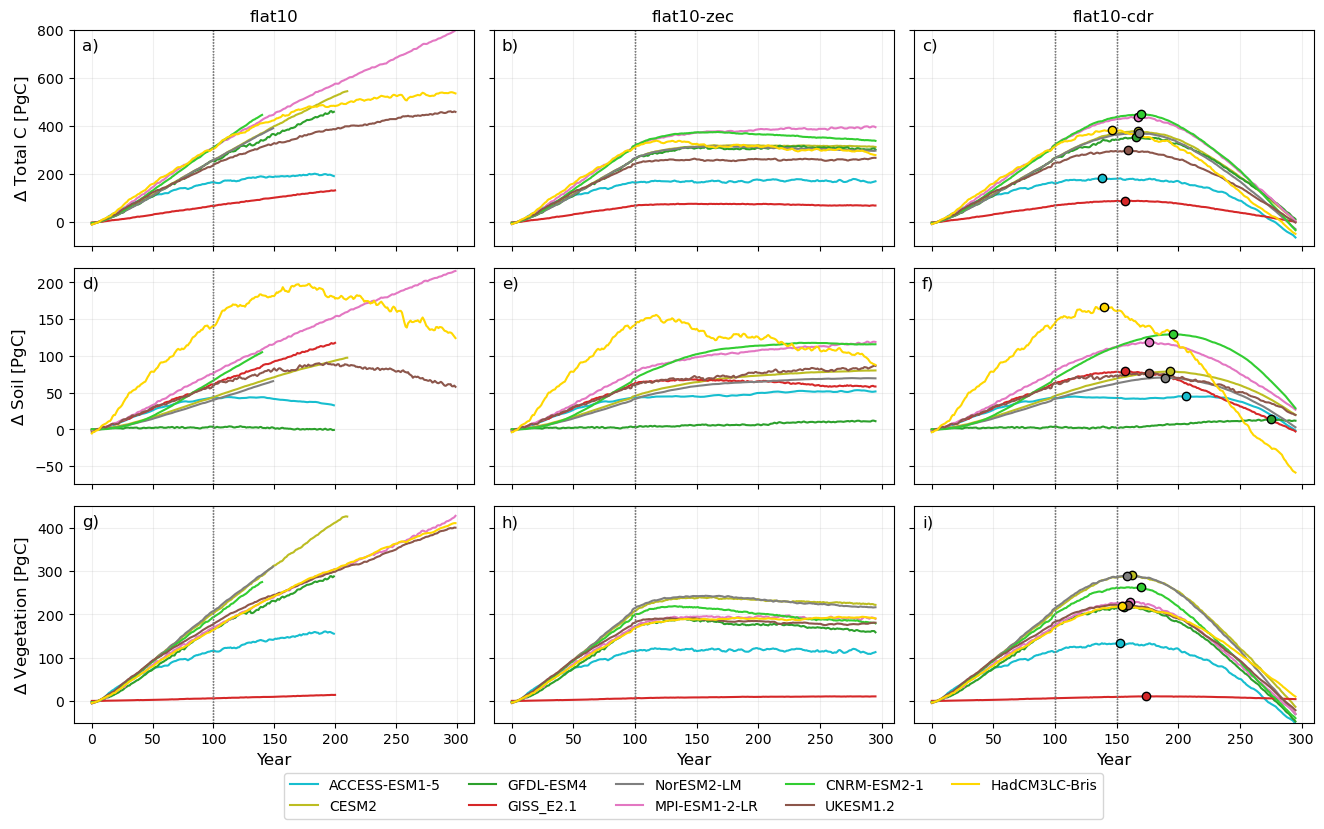

In [13]:
# normalized by initial carbon content, and continuous time series

nr=3
nc=3
fig, axes = plt.subplots(nr,nc,figsize=(16, 9))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change

l=0
varlisthere=['cTot', 'cSoil', 'cVeg']

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    for vi in range(len(varlisthere)):
        var=varlisthere[vi]
        e=0
        timeseriesE=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=var, latrange=latlist[l])
        initC=timeseriesE.data[1:10].mean()

        e=1
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=var, latrange=latlist[l])

        # flat10
        Cts=timeseriesE.data.values
        Cts=Cts[np.where(Cts>0)]- initC.values

        axes[vi,0].plot(Cts[0:300],label=model,color=mcolor)
        axes[vi,0].grid(alpha=0.2)
        axes[vi,0].axvline(100,lw=0.8,color="gray",linestyle=":")

        #flat10 zec
        Cts=np.append(timeseriesE.data[1:99].values, timeseries.data[1:199].values) - initC.values

        axes[vi,1].plot(Cts,label=model,color=mcolor)
        axes[vi,1].grid(alpha=0.2)
        axes[vi,1].axvline(100,lw=0.8,color="gray",linestyle=":")

        e=2
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=var, latrange=latlist[l])

        # flat10 cdr
        Cts=np.append(timeseriesE.data[1:99].values, timeseries.data[1:199].values) - initC.values
        
        
        #Cts=timeseries.data[1:199]-initC
        axes[vi,2].plot(Cts,label=model,color=mcolor)
        axes[vi,2].grid(alpha=0.2)
        axes[vi,2].axvline(100,lw=0.8,color="gray",linestyle=":")
        axes[vi,2].axvline(150,lw=0.8,color="gray",linestyle=":")

        # add dot at maximum value    
        if np.isfinite(np.max(Cts)):
            axes[vi,2].scatter(np.where(Cts==np.max(Cts)),np.max(Cts),color=mcolor,edgecolor="black", zorder=4)
        # np.argwhere(Cts==np.max(Cts))[0]
        # np.where(Cts==np.max(Cts))


axes[0,0].set_title('flat10')
axes[0,1].set_title('flat10-zec')
axes[0,2].set_title('flat10-cdr')

axes[0,0].set_ylabel('$\Delta$ Total C [PgC]',fontsize=12)
axes[1,0].set_ylabel('$\Delta$ Soil [PgC]',fontsize=12)
axes[2,0].set_ylabel('$\Delta$ Vegetation [PgC]',fontsize=12)

for air in range(nr):
    for aic in range(nc):
        axes[2,aic].set_xlabel('Year',fontsize=12)
    
        # axes[ai,0].set_ylabel('$\Delta$ ' +varlisthere[ai] +' [PgC]')
        
        # ylimits
        axes[0,aic].set_ylim([-100,800])
        
        axes[1,aic].set_ylim([-75,220])
        
        axes[2,aic].set_ylim([-50,450])
    
        axes[air,1].yaxis.set_tick_params(labelcolor='none')
        axes[air,2].yaxis.set_tick_params(labelcolor='none')
    
        axes[0,aic].xaxis.set_tick_params(labelcolor='none')
        axes[1,aic].xaxis.set_tick_params(labelcolor='none')
    
        axes[air,aic].annotate(subplotlabelnames[(air+aic)+air*(nc-1)],
                     xy=(0, 1), xycoords='axes fraction',
                     xytext=(+0.5, -0.5), textcoords='offset fontsize',
                     fontsize='large', verticalalignment='top')

axes[2,1].legend(loc='upper center', ncol=5,bbox_to_anchor=(.5, -0.2))#fontsize=6)

plt.subplots_adjust(wspace=0.05, hspace=0.1)


plt.savefig("figures/CtimeseriesDelta_contiuous_allexp_" +latlist[l] +"_PgC.pdf", bbox_inches='tight')
plt.savefig("figures/CtimeseriesDelta_contiuous_allexp_" +latlist[l] +"_PgC.png", bbox_inches='tight')
plt.show()
plt.close()

# Lead lag year

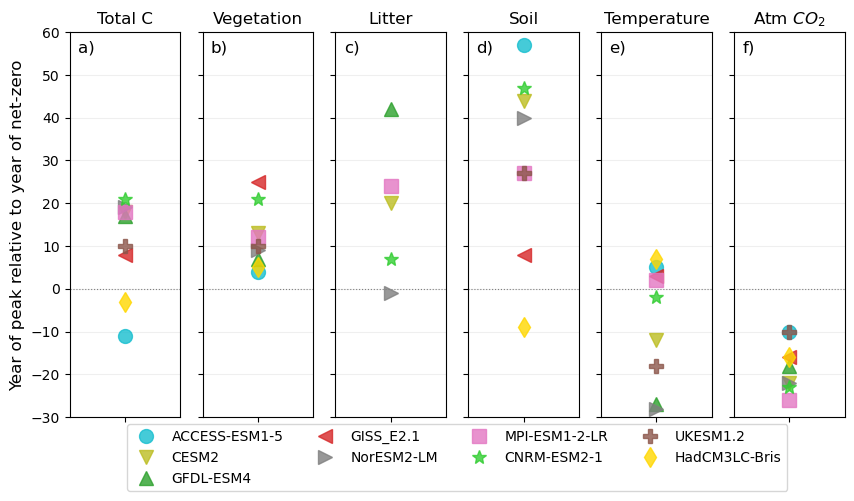

In [14]:
latrange='global'

leadlagpeak = leadlagpeak_global_cdr

fig, ax =plt.subplots(1,6,figsize=(10, 5))

for m in range(len(modellist)):
    model=modellist[m]
    
    ax[0].plot(1, leadlagpeak['cTot'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10,alpha=0.8)
    ax[1].plot(1, leadlagpeak['cVeg'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10,alpha=0.8)
    ax[2].plot(1, leadlagpeak['cLitter'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10,alpha=0.8)
    ax[3].plot(1, leadlagpeak['cSoil'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10,alpha=0.8)
    ax[4].plot(1, leadlagpeak['tas'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10,alpha=0.8)
    ax[5].plot(1, leadlagpeak['co2'][model],color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10,alpha=0.8)


ax[0].set_title('Total C')
ax[1].set_title('Vegetation')
ax[2].set_title('Litter')
ax[3].set_title('Soil')
ax[4].set_title('Temperature')
ax[5].set_title('Atm $CO_2$')

ax[0].set_ylabel('Year of peak relative to year of net-zero',fontsize=12)


for axi in range(6):
    ax[axi].yaxis.grid(alpha=0.2)
    ax[axi].axhline(0,lw=0.8,color="gray",linestyle=":")
    ymin=-30
    ymax=60
    ax[axi].set_ylim([ymin,ymax])
    ax[axi].yaxis.set_ticks(np.arange(ymin,ymax+1,10))
    ax[axi].xaxis.set_ticks([1])
    ax[axi].xaxis.set_tick_params(labelcolor='none')
    if axi>0:
        ax[axi].yaxis.set_tick_params(labelcolor='none')
    # else:
    #     ax[axi].yaxis.set_tick_params(fontsize=12)
        
    ax[axi].annotate(subplotlabelnames[axi],
                     xy=(0, 1), xycoords='axes fraction',
                     xytext=(+0.5, -0.5), textcoords='offset fontsize',
                     fontsize='large', verticalalignment='top')

# ax[5].legend()
lgax=ax[3].legend(loc='upper center', ncol=4,bbox_to_anchor=(-0.1, 0))


# fig.suptitle('year of peak relative to net zero - ' +latrange)

plt.savefig('figures/leadlagpeak_' +latrange +'.pdf', bbox_inches='tight')


# for label, ax in axs.items():
#     # Use Axes.annotate to put the label
#     # - at the top left corner (axes fraction (0, 1)),
#     # - offset half-a-fontsize right and half-a-fontsize down
#     #   (offset fontsize (+0.5, -0.5)),
#     # i.e. just inside the axes.
#     ax.annotate(
#         label,
#         xy=(0, 1), xycoords='axes fraction',
#         xytext=(+0.5, -0.5), textcoords='offset fontsize',
#         fontsize='medium', verticalalignment='top', fontfamily='serif',
#         bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

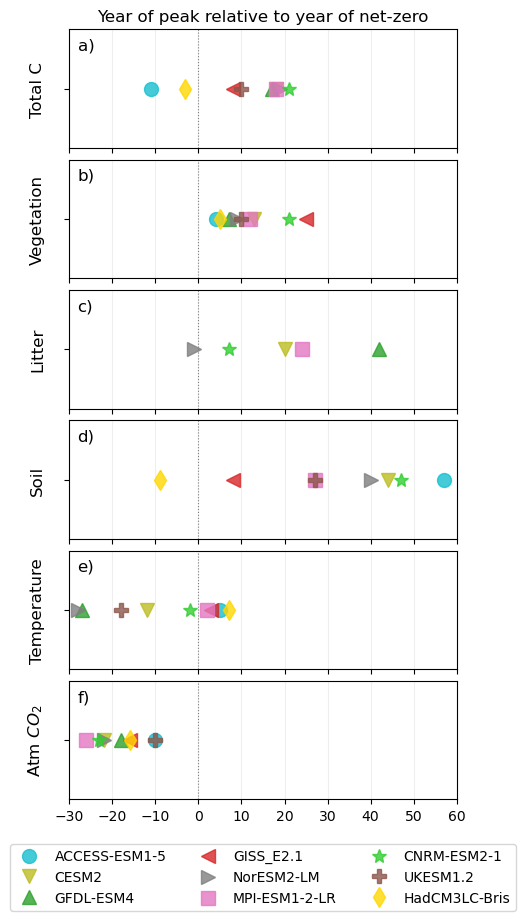

In [15]:
latrange='global'

leadlagpeak = leadlagpeak_global_cdr

nr=6
nc=1
fig, ax =plt.subplots(nr,nc,figsize=(5,10))

plotnames=['Total C', 'Vegetation', 'Litter', 'Soil', 'Temperature','Atm $CO_2$']

for m in range(len(modellist)):
    model=modellist[m]
    
    ax[0].plot(leadlagpeak['cTot'][model],1,color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10,alpha=0.8)
    ax[1].plot(leadlagpeak['cVeg'][model],1,color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10,alpha=0.8)
    ax[2].plot(leadlagpeak['cLitter'][model],1,color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10,alpha=0.8)
    ax[3].plot(leadlagpeak['cSoil'][model],1,color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10,alpha=0.8)
    ax[4].plot(leadlagpeak['tas'][model],1,color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10,alpha=0.8)
    ax[5].plot(leadlagpeak['co2'][model],1,color=modelcolors[m],marker=markerlist[m],linestyle='none',label=model,markersize=10,alpha=0.8)


ax[0].set_title('Year of peak relative to year of net-zero',fontsize=12)


for axi in range(6):
    ax[axi].set_ylabel(plotnames[axi],fontsize=12)
    ax[axi].xaxis.grid(alpha=0.2)
    ax[axi].axvline(0,lw=0.8,color="gray",linestyle=":")
    ymin=-30
    ymax=60
    ax[axi].set_xlim([ymin,ymax])
    ax[axi].xaxis.set_ticks(np.arange(ymin,ymax+1,10))
    ax[axi].yaxis.set_ticks([1])
    ax[axi].yaxis.set_tick_params(labelcolor='none')
    if axi<nr-1:
        ax[axi].xaxis.set_tick_params(labelcolor='none')
    # else:
    #     ax[axi].yaxis.set_tick_params(fontsize=12)
        
    ax[axi].annotate(subplotlabelnames[axi],
                     xy=(0, 1), xycoords='axes fraction',
                     xytext=(+0.5, -0.5), textcoords='offset fontsize',
                     fontsize='large', verticalalignment='top')

# ax[5].legend()
lgax=ax[nr-1].legend(loc='lower center', ncol=3,bbox_to_anchor=(0.5, -1))

fig.subplots_adjust(hspace=0.1)

# fig.suptitle('year of peak relative to net zero - ' +latrange)

plt.savefig('figures/leadlagpeak_sideways_' +latrange +'.pdf', bbox_inches='tight')
plt.show()
plt.close()

# for label, ax in axs.items():
#     # Use Axes.annotate to put the label
#     # - at the top left corner (axes fraction (0, 1)),
#     # - offset half-a-fontsize right and half-a-fontsize down
#     #   (offset fontsize (+0.5, -0.5)),
#     # i.e. just inside the axes.
#     ax.annotate(
#         label,
#         xy=(0, 1), xycoords='axes fraction',
#         xytext=(+0.5, -0.5), textcoords='offset fontsize',
#         fontsize='medium', verticalalignment='top', fontfamily='serif',
#         bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

# Zonal profile plots

Plotting ACCESS-ESM1-5
loading variable: cVeg
finished loading ACCESS-ESM1-5 *lat10 cVeg
loading variable: cVeg
finished loading ACCESS-ESM1-5 *lat10 cVeg
loading variable: cVeg
finished loading ACCESS-ESM1-5 *zec cVeg
loading variable: cVeg
finished loading ACCESS-ESM1-5 *cdr cVeg
loading variable: cSoil
finished loading ACCESS-ESM1-5 *lat10 cSoil
loading variable: cSoil
finished loading ACCESS-ESM1-5 *zec cSoil
loading variable: cSoil
finished loading ACCESS-ESM1-5 *cdr cSoil
loading variable: cLitter
finished loading ACCESS-ESM1-5 *lat10 cLitter
loading variable: cLitter
finished loading ACCESS-ESM1-5 *zec cLitter
loading variable: cLitter
finished loading ACCESS-ESM1-5 *cdr cLitter


/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid

Plotting CESM2
loading variable: cVeg
finished loading CESM2 *lat10 cVeg
loading variable: cVeg
finished loading CESM2 *lat10 cVeg
loading variable: cVeg
finished loading CESM2 *zec cVeg
loading variable: cVeg
finished loading CESM2 *cdr cVeg
loading variable: cSoil
finished loading CESM2 *lat10 cSoil
loading variable: cSoil
finished loading CESM2 *zec cSoil
loading variable: cSoil
finished loading CESM2 *cdr cSoil
loading variable: cLitter
finished loading CESM2 *lat10 cLitter
loading variable: cLitter
finished loading CESM2 *zec cLitter
loading variable: cLitter
finished loading CESM2 *cdr cLitter


/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid

KeyboardInterrupt: 

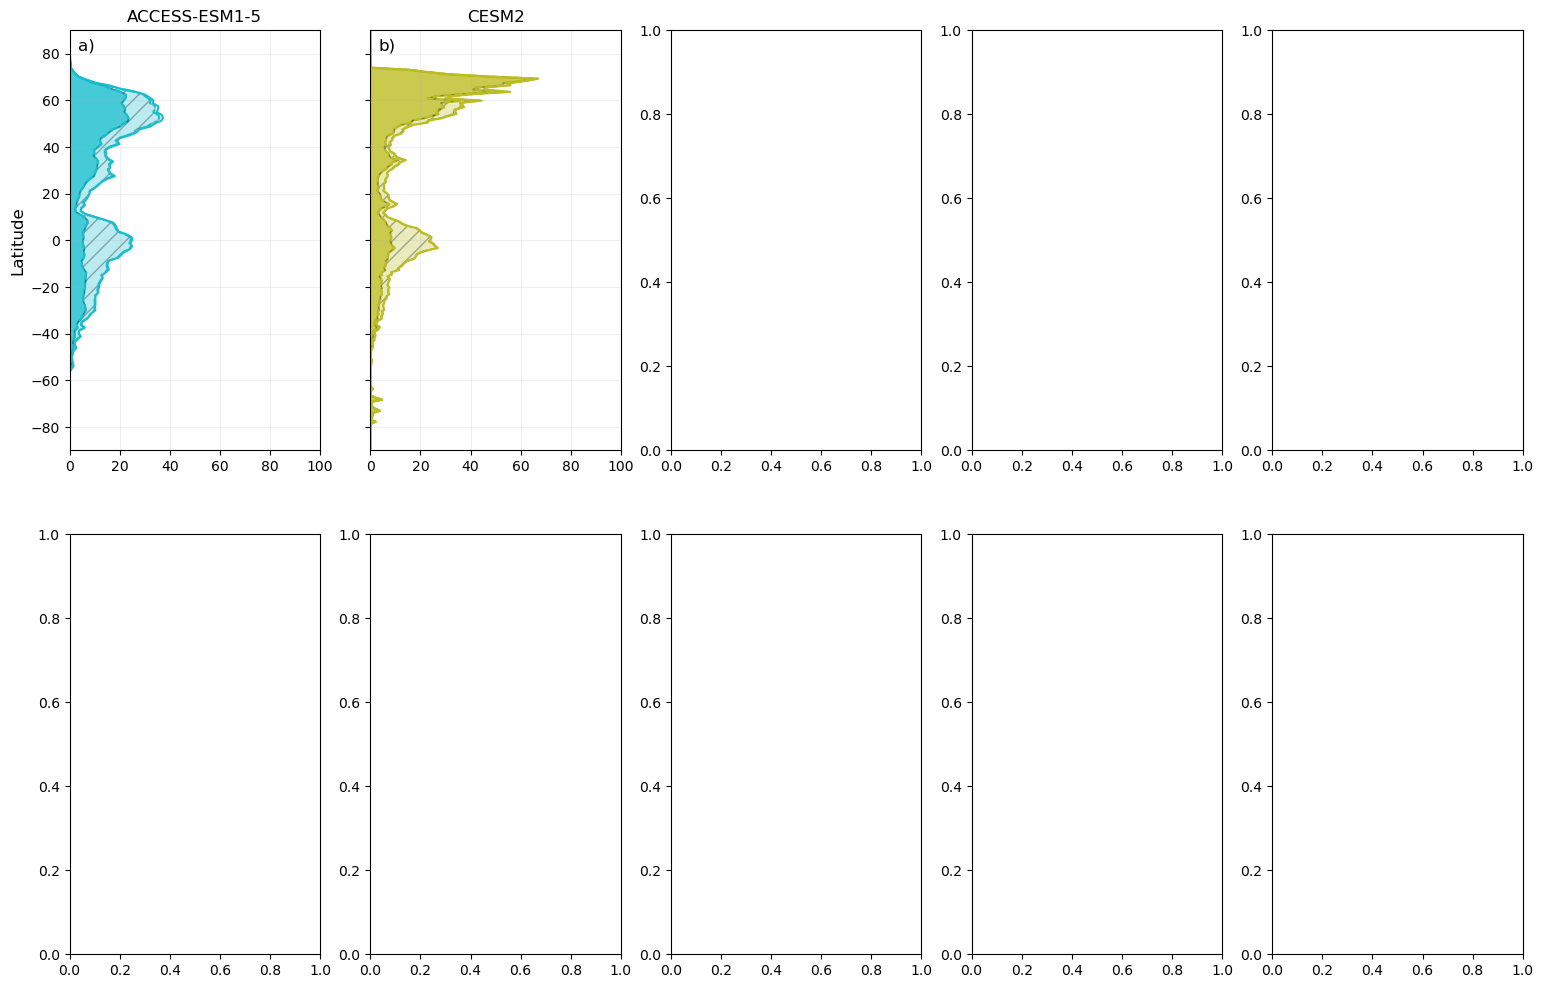

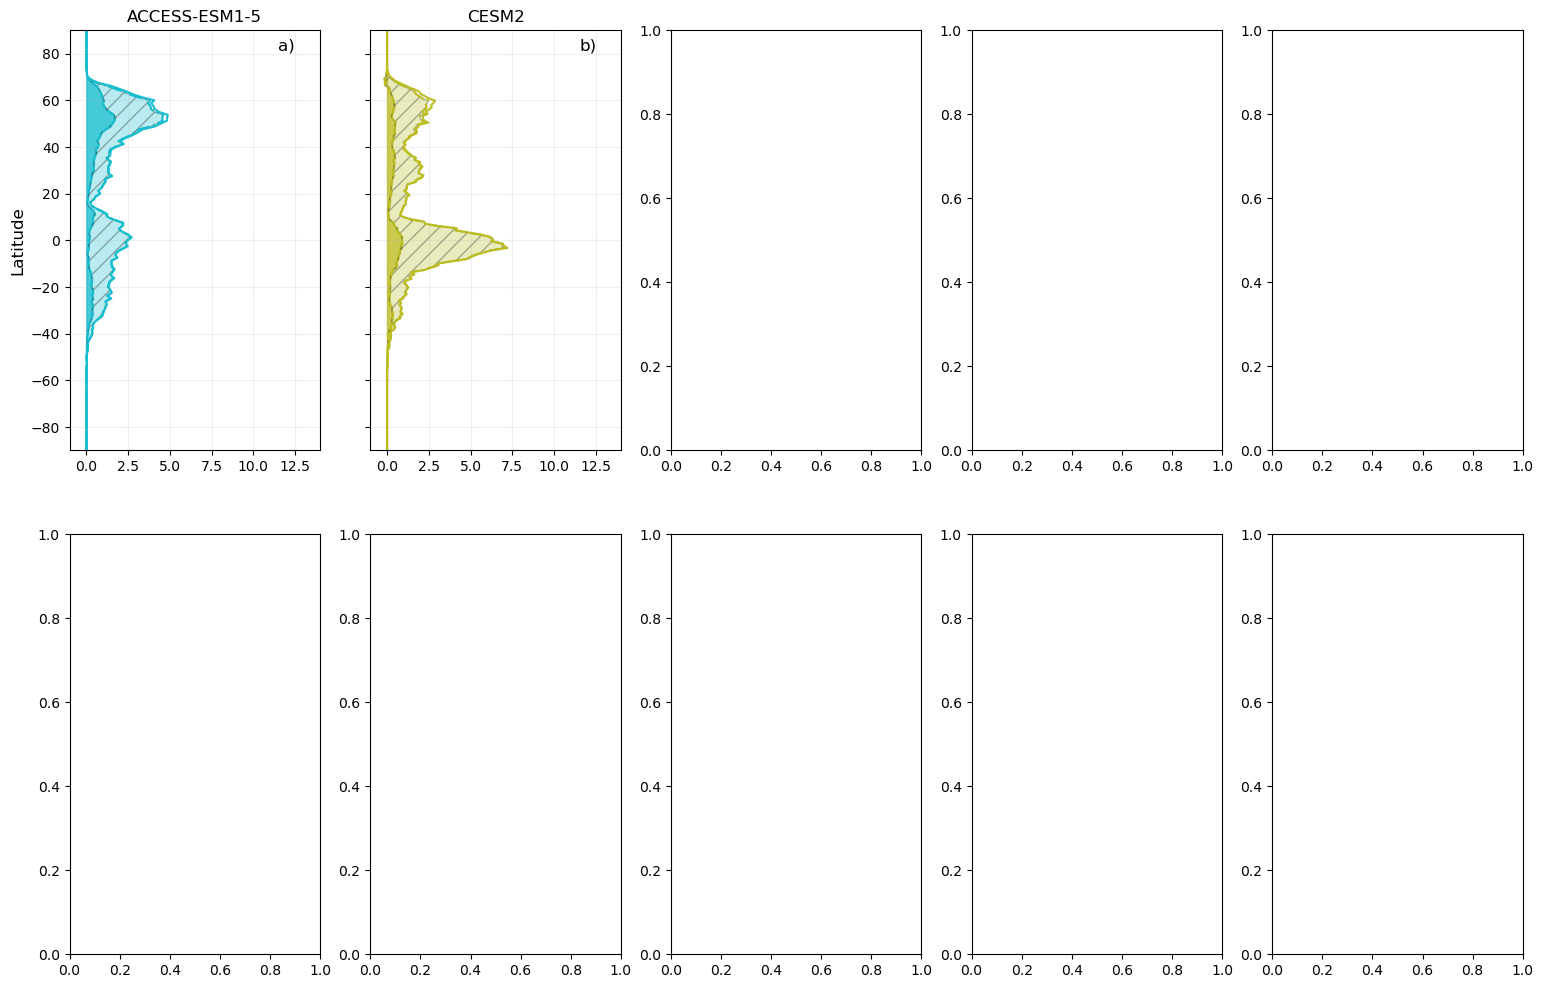

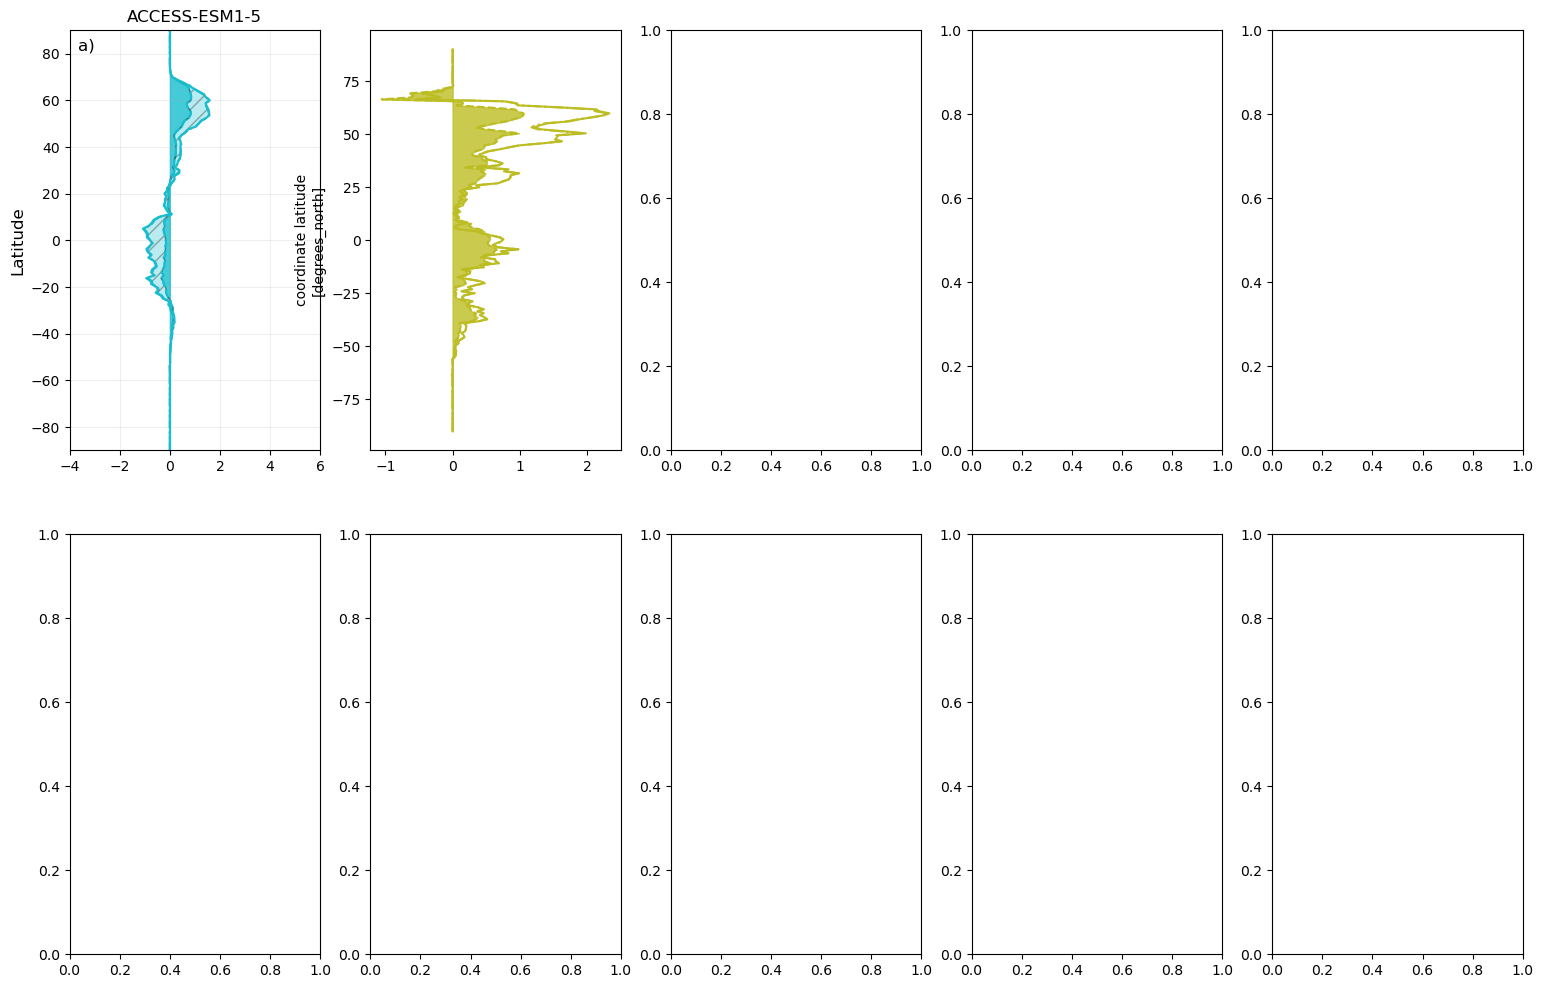

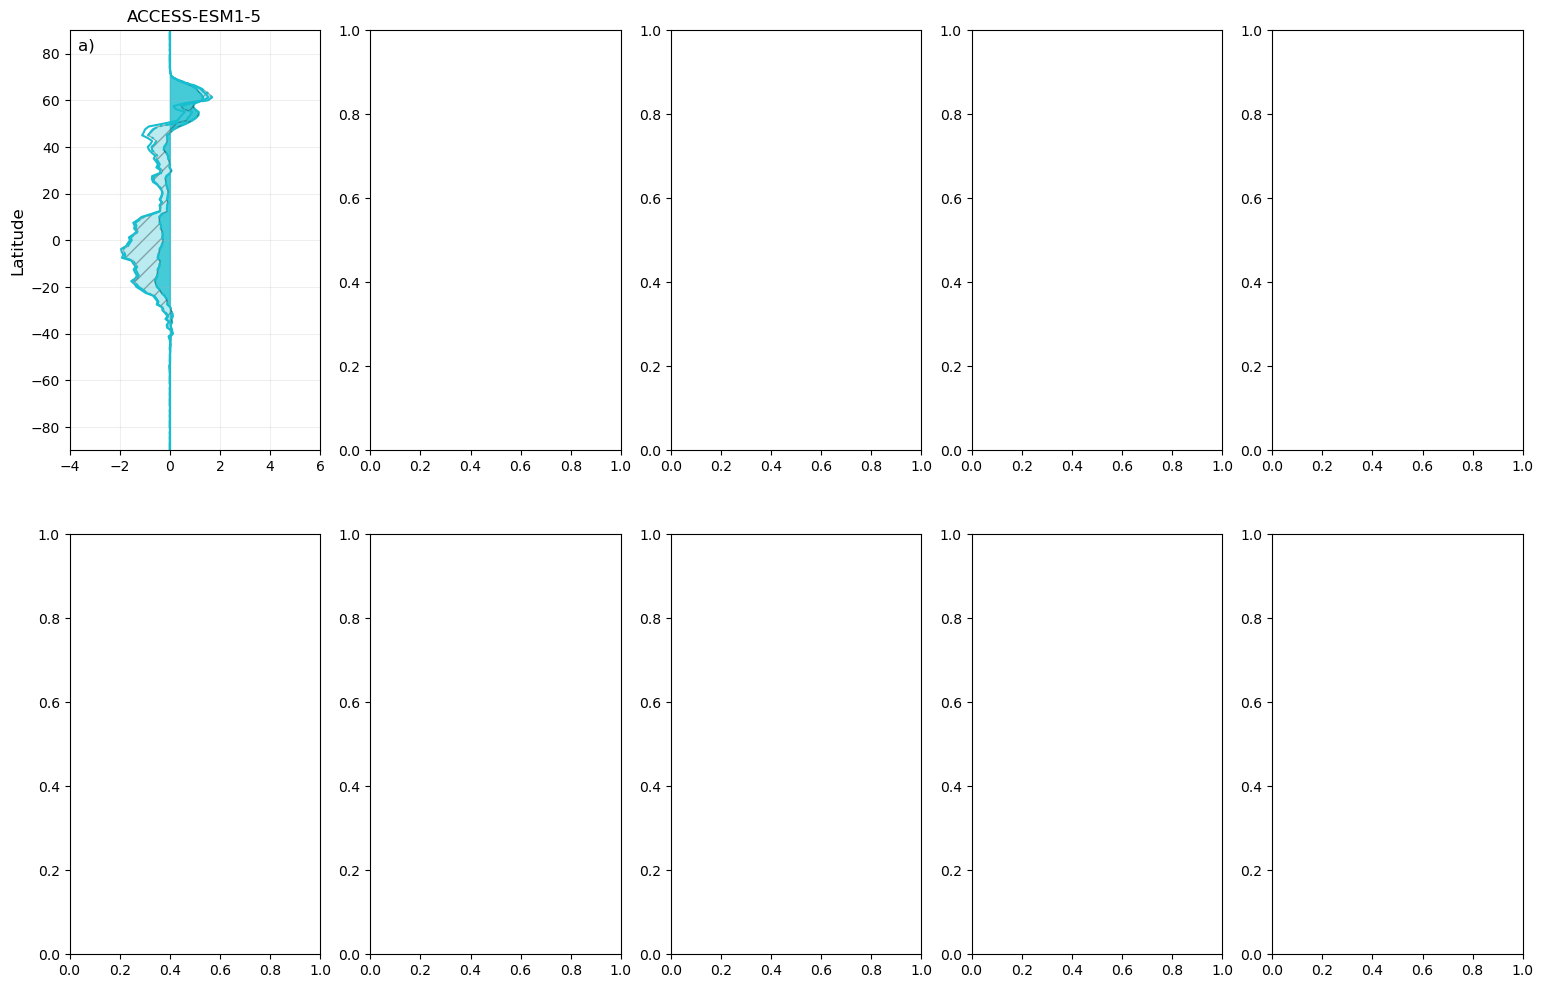

In [16]:
# first column original units (kgC/m2)
# total carbon units (sum of all carbon, not per m2)

phasename=['InitialC','EmissionsPhase','NetZero','CumulativeZero']

num_rows=2
num_cols=5
fig0, axes0 = plt.subplots(num_rows,num_cols,figsize=(3.75 * num_cols, num_rows * 6 )) # initial C
fig1, axes1 = plt.subplots(num_rows,num_cols,figsize=(3.75 * num_cols, num_rows * 6 )) # emissions phase
fig2, axes2 = plt.subplots(num_rows,num_cols,figsize=(3.75 * num_cols, num_rows * 6 )) # net zero
fig3, axes3 = plt.subplots(num_rows,num_cols,figsize=(3.75 * num_cols, num_rows * 6 )) # cumulative zero

axes0=axes0.flatten()
axes1=axes1.flatten()
axes2=axes2.flatten()
axes3=axes3.flatten()


unitconvert=PgperKg
# zonal mean shaded plot, one plot for each model

# loop over models
for m in range(len(modellist)):
    model=modellist[m]
    print('Plotting ' +model)

    mcolor=modelcolors[m]

    # these will be loaded right here
    ds0g=load_one_model_onevar(model,runlist_wc[0],'cVeg')

    ###---- grid info
    lat = ds0g.lat

    #--- get area and land fraction
    ds_area = data_dict[modellist[m] +'_' +'areacella']
    ds_landfrac = data_dict[modellist[m] +'_' +'landfrac']
    
    if model=='CESM2':
        area = ds_area['areacella'].squeeze().reindex_like(ds0g, method='nearest',tolerance=0.05)
    else:
        area = ds_area['areacella'].reindex_like(ds0g, method='nearest',tolerance=0.05)
    
    landfrac=ds_landfrac['sftlf'].reindex_like(ds0g, method='nearest',tolerance=0.05)
    
    if landfrac.max(dim=['lat','lon'])>1: #test if landfrac is on a 0-100 or 0-1 scale
        landfrac=landfrac/100

    landarea=(area*landfrac)
    area_per_lat_m2=(area*landfrac).sum(dim='lon')

    #----###-----####----- cVeg
    var='cVeg'
    ds0=load_one_model_onevar(model,runlist_wc[0],var) #load one model one experiment one var
    # ds0=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds0,var) # annual mean    
    # del ds # drop full grid from memory   
    dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
    dsften_cVeg = dst.mean(dim='time').mean(dim='lon') # original units
    dsften_cVeg_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time') # converted to PgC
    dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
    dslten0_cVeg = dst.mean(dim='time').mean(dim='lon') # original units
    dslten0_cVeg_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC

    ds1=load_one_model_onevar(model,runlist_wc[1],var) #load one model one experiment one var
    # ds1=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds1,var)
    # del ds # drop full grid from memory
    dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
    dslten1_cVeg = dst.mean(dim='time').mean(dim='lon') # original units
    dslten1_cVeg_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC

    ds2=load_one_model_onevar(model,runlist_wc[2],var) #load one model one experiment one var
    # ds2=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds2,var)
    # del ds # drop full grid from memory
    dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
    dslten2_cVeg = dst.mean(dim='time').mean(dim='lon') # original units
    dslten2_cVeg_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC


    #----###-----####----- cSoil
    var='cSoil'
    ds0=load_one_model_onevar(model,runlist_wc[0],var) #load one model one experiment one var
    # ds0=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds0,var) # annual mean    
    # del ds # drop full grid from memory   
    dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
    dsften_cSoil = dst.mean(dim='time').mean(dim='lon') # original units
    dsften_cSoil_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time') # converted to PgC
    dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
    dslten0_cSoil = dst.mean(dim='time').mean(dim='lon') # original units
    dslten0_cSoil_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC

    ds1=load_one_model_onevar(model,runlist_wc[1],var) #load one model one experiment one var
    # ds1=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds1,var)
    # del ds # drop full grid from memory
    dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
    dslten1_cSoil = dst.mean(dim='time').mean(dim='lon') # original units
    dslten1_cSoil_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC

    ds2=load_one_model_onevar(model,runlist_wc[2],var) #load one model one experiment one var
    # ds2=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds2,var)
    # del ds # drop full grid from memory
    dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
    dslten2_cSoil = dst.mean(dim='time').mean(dim='lon') # original units
    dslten2_cSoil_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC


    #----###-----####----- cLitter
    var='cLitter'
    ds0=load_one_model_onevar(model,runlist_wc[0],var) #load one model one experiment one var
    if ds0 is not None:
        # ds0=ds.mean(dim='lon') # zonal mean
        dsw=weighted_temporal_mean(ds0,var) # annual mean    
        # del ds # drop full grid from memory   
        dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
        dsften_cLitter = dst.mean(dim='time').mean(dim='lon') # original units
        dsften_cLitter_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time') # converted to PgC
        dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
        dslten0_cLitter = dst.mean(dim='time').mean(dim='lon') # original units
        dslten0_cLitter_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC
    
        ds1=load_one_model_onevar(model,runlist_wc[1],var) #load one model one experiment one var
        # ds1=ds.mean(dim='lon') # zonal mean
        dsw=weighted_temporal_mean(ds1,var)
        # del ds # drop full grid from memory
        dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
        dslten1_cLitter = dst.mean(dim='time').mean(dim='lon') # original units
        dslten1_cLitter_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC
    
        ds2=load_one_model_onevar(model,runlist_wc[2],var) #load one model one experiment one var
        # ds2=ds.mean(dim='lon') # zonal mean
        dsw=weighted_temporal_mean(ds2,var)
        # del ds # drop full grid from memory
        dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
        dslten2_cLitter = dst .mean(dim='time').mean(dim='lon') # original units
        dslten2_cLitter_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC
    
    
        #----###-----####----- cTot
        # derived variable, sum of Veg, Soil, Litter
        # var='cTot'
        dsften_cTot = dsften_cVeg + dsften_cSoil + dsften_cLitter
        dsften_cTot_PgC = dsften_cVeg_PgC + dsften_cSoil_PgC + dsften_cLitter_PgC
        dslten0_cTot = dslten0_cVeg + dslten0_cSoil + dslten0_cLitter
        dslten0_cTot_PgC = dslten0_cVeg_PgC + dslten0_cSoil_PgC + dslten0_cLitter_PgC
        dslten1_cTot = dslten1_cVeg + dslten1_cSoil + dslten1_cLitter
        dslten1_cTot_PgC = dslten1_cVeg_PgC + dslten1_cSoil_PgC + dslten1_cLitter_PgC
        dslten2_cTot = dslten2_cVeg + dslten2_cSoil + dslten2_cLitter
        dslten2_cTot_PgC = dslten2_cVeg_PgC + dslten2_cSoil_PgC + dslten2_cLitter_PgC

    else: # litter variable doesn't exist
        #----###-----####----- cTot
        # derived variable, sum of Veg, Soil, but NOT litter
        # var='cTot'
        dsften_cTot = dsften_cVeg + dsften_cSoil
        dsften_cTot_PgC = dsften_cVeg_PgC + dsften_cSoil_PgC
        dslten0_cTot = dslten0_cVeg + dslten0_cSoil 
        dslten0_cTot_PgC = dslten0_cVeg_PgC + dslten0_cSoil_PgC 
        dslten1_cTot = dslten1_cVeg + dslten1_cSoil 
        dslten1_cTot_PgC = dslten1_cVeg_PgC + dslten1_cSoil_PgC 
        dslten2_cTot = dslten2_cVeg + dslten2_cSoil 
        dslten2_cTot_PgC = dslten2_cVeg_PgC + dslten2_cSoil_PgC 

    #  drop some things from memory
    del ds0, ds1, ds2
    
    ###----------------------Plot-------------------------###

    # to use, refer to one index in axs: ax = axs[row, column]


    #--------------------------Second row is total carbon units (PgC)
    #---First column is flat10 climatology
    #--- first figure is the climatology, or average of first 10 years 
    ax = axes0[m]


    # plot lines soil, veg + soil, total-litter, total
#    dsften_cTot.plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total')
#    dsften_cSoil.plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
#    (dsften_cVeg+dsften_cSoil).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    ax.plot(dsften_cTot_PgC,lat, linestyle='-',color=mcolor,label='Total C')
    ax.plot(dsften_cSoil_PgC,lat, linestyle='--',color=mcolor,label='_nolabel_')
    ax.plot((dsften_cVeg_PgC+dsften_cSoil_PgC),lat, linestyle='-.',color=mcolor,label='_nolabel_')

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dsften_cSoil_PgC,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dsften_cSoil_PgC,dsften_cSoil_PgC+dsften_cVeg_PgC,alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

    ax.set_ylim([-90, 90])
    ax.grid(True,alpha=0.2, zorder=0)
    ax.set_ylabel('Latitude',fontsize=12)
    ax.set_title(model)
    if (m!=0 and m!=num_cols): #remove y ticks for plots that are not on the left hand edge of the plot
        ax.set_yticklabels([])
        ax.set_ylabel('')
    ax.set_xlim([0, 100])

    if m>num_cols-1:
        ax.set_xlabel('[PgC]')
    ax.annotate(subplotlabelnames[m],
                         xy=(0, 1), xycoords='axes fraction',
                         xytext=(+0.5, -0.5), textcoords='offset fontsize',
                         fontsize='large', verticalalignment='top')
    
    #--- Second figure is end of flat10 emissions phase
    ax = axes1[m]
    #dsdelta=(dslten0.mean(dim='time')-dsften.mean(dim='time')).mean(dim='lon') #last 10 years of flat10 minus first ten years of flat10-zec
    #.plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor)
    

    # plot lines soil, veg + soil, total-litter, total
    (dslten0_cTot_PgC-dsften_cTot_PgC).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total C')
    (dslten0_cSoil_PgC-dsften_cSoil_PgC).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((dslten0_cVeg_PgC+dslten0_cSoil_PgC)-(dsften_cVeg_PgC+dsften_cSoil_PgC)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dslten0_cSoil_PgC-dsften_cSoil_PgC,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dslten0_cSoil_PgC-dsften_cSoil_PgC,(dslten0_cSoil_PgC-dsften_cSoil_PgC)+(dslten0_cVeg_PgC-dsften_cVeg_PgC),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

    ax.set_ylim([-90, 90])
    ax.grid(True,alpha=0.2, zorder=0)
    ax.set_ylabel('Latitude',fontsize=12)
    ax.set_title(model)
    if (m!=0 and m!=num_cols): #remove y ticks for plots that are not on the left hand edge of the plot
        ax.set_yticklabels([])
        ax.set_ylabel('')

    ax.set_xlim([-1, 14])
    ax.annotate(subplotlabelnames[m],
                         xy=(0.8, 1), xycoords='axes fraction',
                         xytext=(+0.5, -0.5), textcoords='offset fontsize',
                         fontsize='large', verticalalignment='top')

    if m>num_cols-1:
        ax.set_xlabel('[PgC]')

    #--- Third figure is end of flat10zec phase
    ax = axes2[m] 
    #dsdelta=dslten1.mean(dim='time')-dslten0.mean(dim='time') #last 10 years of flat10-zec minus last 10 years of flat10
    #fg = dsdelta.mean(dim='lon').plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor) 

    # plot lines soil, veg + soil, total-litter, total
    (dslten1_cTot_PgC-dslten0_cTot_PgC).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total C')
    (dslten1_cSoil_PgC-dslten0_cSoil_PgC).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((dslten1_cVeg_PgC+dslten1_cSoil_PgC)-(dslten0_cVeg_PgC+dslten0_cSoil_PgC)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dslten1_cSoil_PgC-dslten0_cSoil_PgC,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dslten1_cSoil_PgC-dslten0_cSoil_PgC,(dslten1_cSoil_PgC-dslten0_cSoil_PgC)+(dslten1_cVeg_PgC-dslten0_cVeg_PgC),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

    ax.set_ylim([-90, 90])
    ax.grid(True,alpha=0.2, zorder=0)
    ax.set_ylabel('Latitude',fontsize=12)
    ax.set_title(model)
    if (m!=0 and m!=num_cols): #remove y ticks for plots that are not on the left hand edge of the plot
        ax.set_yticklabels([])
        ax.set_ylabel('')
    ax.set_xlim([-4, 6])
    ax.annotate(subplotlabelnames[m],
                         xy=(0, 1), xycoords='axes fraction',
                         xytext=(+0.5, -0.5), textcoords='offset fontsize',
                         fontsize='large', verticalalignment='top')
    
    if m>num_cols-1:
        ax.set_xlabel('[PgC]')
        
    #--- Fourth figure is end of flat10cdr phase

    ax = axes3[m] 

    #dsdelta=dslten2.mean(dim='time')-dsften.mean(dim='time') #last 10 years of flat10-cdr minus first ten years of flat10
    #fg = dsdelta.mean(dim='lon').plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor) 


    # plot lines soil, veg + soil, total-litter, total
    (dslten2_cTot_PgC-dsften_cTot_PgC).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total C')
    (dslten2_cSoil_PgC-dsften_cSoil_PgC).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((dslten2_cVeg_PgC+dslten2_cSoil_PgC)-(dsften_cVeg_PgC+dsften_cSoil_PgC)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)
    
    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dslten2_cSoil_PgC-dsften_cSoil_PgC,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dslten2_cSoil_PgC-dsften_cSoil_PgC,(dslten2_cSoil_PgC-dsften_cSoil_PgC)+(dslten2_cVeg_PgC-dsften_cVeg_PgC),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

    ax.set_ylim([-90, 90])
    ax.grid(True,alpha=0.2, zorder=0)
    ax.set_ylabel('Latitude',fontsize=12)
    ax.set_title(model)
    if (m!=0 and m!=num_cols): #remove y ticks for plots that are not on the left hand edge of the plot
        ax.set_yticklabels([])
        ax.set_ylabel('')
    ax.set_xlim([-4, 6])

    if m>num_cols-2:
        ax.set_xlabel('[PgC]')

    ax.annotate(subplotlabelnames[m],
                         xy=(0, 1), xycoords='axes fraction',
                         xytext=(+0.5, -0.5), textcoords='offset fontsize',
                         fontsize='large', verticalalignment='top')




# add gridlines
#axes0[m].grid(True,alpha=0.2, zorder=0)

# add legend
axes0[0].legend(loc='lower right')
axes1[0].legend(loc='lower right')
axes2[0].legend(loc='lower right')
axes3[0].legend(loc='lower right')

# add a zonal profile of observed c pools on the ititial C plot (axes0)
ax=axes0[9]
cSoil, cVeg, cSoil_zonal, cVeg_zonal=load_observations(1) #load the data
lat=cVeg_zonal.lat
fg = ax.fill_betweenx(lat,0, cSoil_zonal.values,alpha=0.8,color=soilcolor,label='Soil')
fg2 = ax.fill_betweenx(lat,cSoil_zonal.values, cSoil_zonal.values+cVeg_zonal.values,color=vegcolor,label='Veg',hatch='//',edgecolor='grey')

ax.set_title('Observations')
ax.set_ylim([-90, 90])
ax.set_yticklabels([])
ax.set_ylabel('')
ax.grid(True,alpha=0.2, zorder=0)
ax.set_xlim([0,100])
ax.set_xlabel('[PgC]')
ax.legend(loc='lower right')
ax.annotate(subplotlabelnames[9],
                         xy=(0, 1), xycoords='axes fraction',
                         xytext=(+0.5, -0.5), textcoords='offset fontsize',
                         fontsize='large', verticalalignment='top')

# remve the empty plot in the last slot - if we add a 10th model will need to disable this!
# axes0[9].set_visible(False) 
axes1[9].set_visible(False)
axes2[9].set_visible(False) 
axes3[9].set_visible(False)

# set title over whole plot
yh=0.92
fig0.suptitle('Initial Carbon Stocks (beginning of flat10)',y=yh)
fig1.suptitle('Carbon gained during emissions phase (end of flat10 - beginning of flat10)',y=yh)
fig2.suptitle('Carbon change after net-zero (end of flat10zec - end of flat10)',y=yh)
fig3.suptitle('Carbon change at cumulative zero emissions (end of flat10cdr - beginning of flat10)',y=yh)

# save the plot
fig0.savefig('figures/' +'Cdelta_zonal_lineplot_allmodels_' +phasename[0] +'.png', bbox_inches='tight', dpi=400)
plt.show(fig0)
plt.close(fig0)

fig1.savefig('figures/' +'Cdelta_zonal_lineplot_allmodels_' +phasename[1] +'.png', bbox_inches='tight', dpi=400)
plt.show(fig1)
plt.close(fig1)

fig2.savefig('figures/' +'Cdelta_zonal_lineplot_allmodels_' +phasename[2] +'.png', bbox_inches='tight', dpi=400)
plt.show(fig2)
plt.close(fig2)

fig3.savefig('figures/' +'Cdelta_zonal_lineplot_allmodels_' +phasename[3] +'.png', bbox_inches='tight', dpi=400)
plt.show(fig3)
plt.close(fig3)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
# plt.close()


# IRF fit

# Print tables to screen

In [ ]:
veg_stock_delta_cTot

In [ ]:
veg_stock_delta_global

In [ ]:
veg_stock_delta_highlat

In [ ]:
veg_stock_delta_midlat

In [ ]:
veg_stock_delta_troplat

In [ ]:
leadlagpeak_global_cdr

In [ ]:
# it's possible to print these dataframes to latex tables like this:

df=leadlagpeak_global_cdr
# print(df.style.Styler.to_latex(float_format="{:.1f}".format)) #'tables/leadlagpeak_global_cdr.tex'

print(df.to_latex(float_format="{:.1f}".format))#,'tables/leadlagpeak_global_cdr.tex')

In [ ]:
df=veg_stock_delta_cTot
# print(df.style.Styler.to_latex(float_format="{:.1f}".format)) #'tables/leadlagpeak_global_cdr.tex'

# print(df.to_latex(float_format="{:.1f}".format))